**Hash Function**

In [1]:
!pip install openai-clip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.2 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=efc5825bd6a8507ffa1f53a9021088459aa392ae8b3a4ad5b5c7a65c936576c1
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


**Clip Encoder**

In [2]:
"""
This file is used to encode the images into clip vector
"""

import torch
import clip
from PIL import Image

class Vectorizer:
    def __init__(self) -> None:
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)

    def vectorize_img(self,pilImg):

        assert isinstance(pilImg, Image.Image), "Input is not a PIL image."

        image = self.preprocess(pilImg).unsqueeze(0).to(self.device)
        with torch.no_grad():
            image_features = self.model.encode_image(image)

        return image_features


    def vectorize_text(self,text):
        assert type(text) == str, "Expected text to be of type string"

        text = clip.tokenize([text]).to(self.device)

        with torch.no_grad():
            text_features = self.model.encode_text(text)

        return text_features


Xor Function

In [3]:
"""
This file is used to vectorize the whole target file
"""

import os
import torch

class Processor:
    """can be used to obtain the vectors of chunks from file"""
    def __init__(self,chunk_size=30) -> None:
        self.vectorizer = Vectorizer()
        self.chunk_size = chunk_size
        self.unique_feature = None

    def getXors(self,vecs):
        scale = 10

        assert type(vecs) is list ,"expected a list"

        elems = len(vecs)
        base = (vecs[0]*scale).to(torch.int)

        for i in range(1,elems):
            base = base ^ ((scale*vecs[i]).to(torch.int))


        # adding additional layer of security by using feature specific to the file being hashed only

        base = (base ^ ((scale*self.unique_feature).to(torch.int))).tolist()

        return base

    def getVecs(self,fileName):

        """returns list of vectors expects filename as input"""

        assert os.path.isfile(fileName),f"No file found at {fileName}"

        vectors_list = []


        with open(fileName,"r") as file:
            lines = file.readlines()

        all_text = ".".join(lines)

        max_len = len(all_text)

        start = 0
        end = min(self.chunk_size,max_len)


        while(end<max_len):


            chunk = all_text[start:end]
            vec = torch.squeeze(self.vectorizer.vectorize_text(chunk))
            vectors_list.append(vec)

            start = end
            end += self.chunk_size

            end = min(end,max_len)

        chunk = all_text[start:end]
        vec = torch.squeeze(self.vectorizer.vectorize_text(chunk))
        vectors_list.append(vec)

        # creating unique feature vector
        if len(lines) > 1:
          split_line = lines[1].split(" ")
        else:
          split_line = lines[0].split(" ")

        if len(split_line) >= 3:
            self.unique_feature = torch.squeeze(self.vectorizer.vectorize_text(split_line[2]))
        else:
            self.unique_feature = torch.squeeze(self.vectorizer.vectorize_text(split_line[0]))

        return vectors_list

    def gethash(self,fileName):
        vecs = self.getVecs(fileName)
        digest = self.getXors(vecs)



        hash = " ".join(str(abs(item)) for item in digest)


        return hash


**Semantic Attack Strong Collision Resistance**


In [4]:
import json
import hashlib
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
hasher = Processor()

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 170MiB/s]


In [ ]:
def parse_document(document):
    # Your document parsing logic goes here
    # This is a placeholder example:
    parsed_data = {
        "text": document,
        "hash": hasher.gethash(document)
    }
    return parsed_data

In [ ]:
def save_to_json(parsed_data, filename):
    output_filename = filename + ".json"
    with open(output_filename, "w") as json_file:
        json.dump(parsed_data, json_file, indent=4)
    return output_filename

In [ ]:
def check_duplicates(new_file, existing_files):
    new_hash = new_file["hash"]
    for filename, parsed_data in existing_files.items():
        if parsed_data["hash"] == new_hash:
            return filename
    return None


In [ ]:
def main():
    input_directory = "/content/documents"
    output_directory = "parsed_documents"
    duplicates_file = "duplicates.json"
    existing_files = {}

    # Check if output directory exists, if not, create it
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(input_directory):
        # with open(os.path.join(input_directory, filename), "r") as file:
        #     # document = file.read()
            parsed_data = parse_document(os.path.join(input_directory, filename))
            duplicate_filename = check_duplicates(parsed_data, existing_files)
            if duplicate_filename:
                print(f"Found duplicate content in {filename} and {duplicate_filename}.")
                existing_files[duplicate_filename]["duplicates"].append(filename)
                continue
            output_filename = save_to_json(parsed_data, os.path.splitext(filename)[0])
            existing_files[output_filename] = {"hash": parsed_data["hash"], "duplicates": [filename]}

    # Writing duplicates information to a JSON file
    with open(duplicates_file, "w") as dup_json_file:
        json.dump(existing_files, dup_json_file, indent=4)

In [ ]:
if __name__ == "__main__":
    main()


In [ ]:
file1 = "doc1_2.json"
file2 = "doc1_3.json"
file3 = "doc1_1.json"

In [ ]:
import json
import matplotlib.pyplot as plt

def read_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data["hash"]

def calculate_char_match(hash1, hash2):
    char_match_count = sum(c1 == c2 for c1, c2 in zip(hash1, hash2))
    return char_match_count

def calculate_total_chars(hash1, hash2):
    total_chars_count = len(hash1) + len(hash2)
    return total_chars_count

def main():
    file1_hash = read_json(file1)
    file2_hash = read_json(file2)
    file3_hash = read_json(file3)

    # Calculate the maximum number of characters in any file's hash
    max_chars = max(len(file1_hash), len(file2_hash), len(file3_hash))

    # Calculate the number of matched characters in hash values
    char_match_file1_file2 = calculate_char_match(file1_hash, file2_hash)
    char_match_file1_file3 = calculate_char_match(file1_hash, file3_hash)
    char_match_file2_file3 = calculate_char_match(file2_hash, file3_hash)

    print("Number of matched characters between File 1 and File 2:", char_match_file1_file2)
    print("Number of matched characters between File 1 and File 3:", char_match_file1_file3)
    print("Number of matched characters between File 2 and File 3:", char_match_file2_file3)

    # Visualize the relationship between matched and mismatched characters
    labels = ['Max Characters', 'File 1 & File 2', 'File 1 & File 3', 'File 2 & File 3']
    values = [max_chars, char_match_file1_file2, char_match_file1_file3, char_match_file2_file3]

    plt.bar(labels, values, color = ['#4CAF50', '#2196F3', '#FF9800', '#FF5722']
)
    plt.xlabel('File Pairs')
    plt.ylabel('Characters')
    plt.title('Max Characters and Matched Characters in Hash Values')
    plt.show()

if __name__ == "__main__":
    main()


**Weak Collision resistance attack**

In [6]:
def save_modified_text(filename, text):
    # Constructing the filename for the modified text
    modified_filename = os.path.splitext(filename)[0] + "_modified.txt"

    # Saving the modified text to the file
    with open(modified_filename, "w") as file:
        file.write(text)

    return modified_filename

In [7]:
def parse_document(filename):

    modified_documents = []

    try:
        with open(filename, "r") as file:
            lines = file.read()

        all_text = "".join(lines)
        max_len = len(all_text)

        first_doc = {"text": lines , "hash": hasher.gethash(filename)}
        modified_documents.append(first_doc)

        for i in range(max_len):
            modified_text = all_text[:i] + chr((ord(all_text[i]) + 1) % 256) + all_text[i+1:]
            # Save the modified text to a separate file
            modified_filename = save_modified_text(filename, modified_text)

            hash_value = hasher.gethash(modified_filename)

            modified_doc = {"text": modified_text, "hash": hash_value}

            modified_documents.append(modified_doc)

        return modified_documents

    except FileNotFoundError:
        print("File not found.")
        return []

In [8]:
def save_to_json(documents, filename):
    with open(filename, "w") as json_file:
        json.dump(documents, json_file, indent=4)

In [9]:
def load_documents(filename):
    try:
        with open(filename, "r") as json_file:
            documents = json.load(json_file)
    except FileNotFoundError:
        documents = []
    return documents

In [10]:
def check_duplicate_hash(new_hash, documents):
    for doc in documents:
        if doc["hash"] == new_hash:
            return doc["text"]
    return None

In [15]:
def main(input_file, saved_documents_file):
    output_file = "parsed_document.json"

    # Load existing documents
    saved_documents = load_documents(saved_documents_file)

    try:
        modified_documents = parse_document(input_file)

        for modified_doc in modified_documents:
            if check_duplicate_hash(modified_doc["hash"], saved_documents):
                print(f"Found duplicate content for hash: {modified_doc['text']} :  {modified_doc['hash']}")
                continue

            # Save modified document to the list of saved documents
            saved_documents.append(modified_doc)

        # Save the list of modified documents to a single JSON file
        save_to_json(saved_documents, saved_documents_file)

        print("Document processed successfully.")


    except FileNotFoundError:
        print("File not found.")

In [12]:
def graphPlotter(json_file):

  # Read data from JSON file
  with open(json_file, 'r') as file:
      data = json.load(file)

  # Calculate hash difference
  hash_diff = [0]
  for i in range(1, len(data)):
      diff = sum(1 for x, y in zip(data[0]['hash'], data[i]['hash']) if x != y)
      hash_diff.append(diff)

  # Plotting
  plt.figure(figsize=(10, 6))
  plt.plot(range(len(hash_diff)), hash_diff, marker='o', linestyle='-', color='b')
  plt.title('Hash Difference for Changing a Single Character')
  plt.xlabel('Index of Character Changed')
  plt.ylabel('Hash Difference')
  plt.xticks([0, len(data) - 1], [f'Change 1', f'Change {len(data)}'])
  plt.grid(True)
  plt.show()


Document processed successfully.


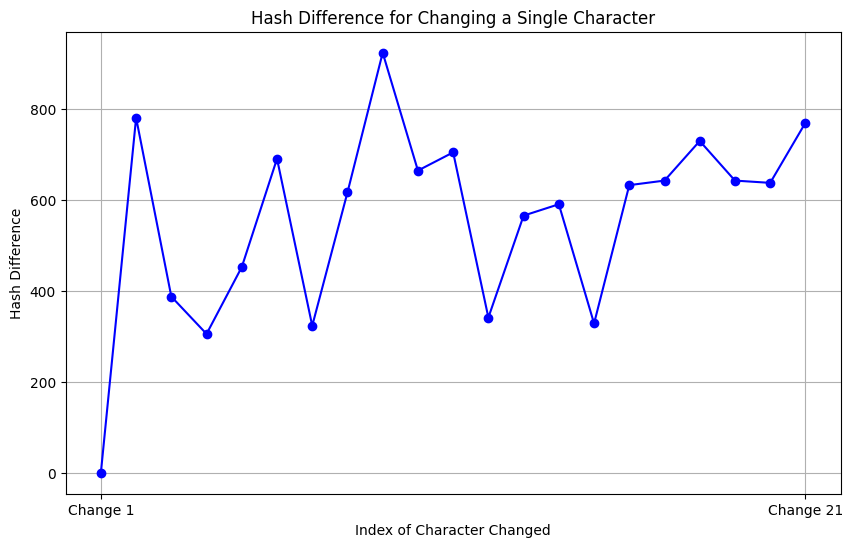

In [16]:
if __name__ == "__main__":
    input_file = "/content/input.txt"
    saved_documents_file = "saved_documents.json"
    main(input_file, saved_documents_file)
    graphPlotter(saved_documents_file)


In [18]:
hash_val = hasher.gethash("input.txt")
with open("input.txt","r") as file:
  text = file.read()

print("Content : ", text)
print("Hash : ",hash_val)

Content :  this is a test file.
Hash :  1 3 3 1 2 1 2 13 1 7 1 1 2 2 0 1 6 1 2 4 2 3 0 3 2 3 2 0 1 3 2 0 1 2 4 0 2 1 3 2 0 2 3 2 2 4 4 1 1 2 2 2 1 0 3 1 3 2 2 0 7 1 3 2 1 0 1 2 4 1 1 1 3 1 0 1 3 3 1 1 3 0 1 0 0 3 3 3 3 2 0 0 3 2 1 4 1 0 3 0 3 1 2 3 3 0 0 1 1 1 1 0 1 1 1 2 4 2 4 0 1 2 0 0 1 0 3 1 2 4 0 2 3 6 6 4 1 3 1 1 1 1 1 7 3 2 0 1 3 1 1 1 3 2 1 0 4 1 3 4 5 3 0 2 4 1 2 1 1 2 1 2 3 1 4 2 1 0 3 2 2 0 3 3 1 5 0 4 2 3 2 1 0 1 0 2 1 2 0 0 2 2 1 3 2 0 0 4 4 0 5 5 2 1 2 1 1 1 2 4 2 3 0 2 1 0 0 1 4 1 1 2 2 1 0 1 3 1 1 2 0 6 2 1 0 1 0 2 2 2 3 2 3 3 3 0 2 0 0 7 2 0 6 2 4 3 2 2 2 3 0 1 4 5 0 0 2 3 1 0 1 0 1 4 0 2 2 2 1 0 4 3 2 3 0 0 5 1 1 4 0 2 1 2 1 1 0 0 1 2 0 4 6 0 1 1 2 6 1 0 0 0 3 1 0 1 1 1 1 15 0 2 2 0 3 3 1 3 2 3 0 4 2 4 0 1 0 3 3 1 4 1 1 1 0 0 0 4 1 0 3 3 3 6 1 1 2 1 2 3 0 0 0 3 4 0 3 1 11 0 1 0 0 7 1 1 1 2 1 1 6 4 0 4 2 1 1 3 3 3 0 0 0 0 1 3 1 1 4 1 1 0 4 3 1 0 1 2 0 2 0 1 2 0 3 2 2 3 2 4 1 2 0 1 1 1 1 0 1 0 1 3 2 1 1 4 1 3 2 3 1 3 0 6 0 5 2 3 2 1 2 0 2 0 5 1 3 2 0 1 1 2 7 0 4 3 0 0 2